### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'drugs_rating', # dataset name
    'source': 'kaggle', # ['local', 'kaggle', 'openml', ''hf]
    'remote_path': 'jithinanievarghese/drugs-side-effects-and-medical-condition',
    'files': ['drugs_side_effects_drugs_com.csv'],
    'rename_files': ['drugs_rating.csv'],
    'task': 'reg', # ['reg', 'cls']
    'target': 'rating', # target column name
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset not downloaded yet. Downloading to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/drugs_rating.
Info: Downloaded: drugs_side_effects_drugs_com.csv from Kaggle to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/drugs_rating.
Info: Unzipped the file '/media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/drugs_rating/drugs_side_effects_drugs_com.csv.zip'.
Info: No unlisted files found in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/drugs_rating.
Info: Renamed drugs_side_effects_drugs_com.csv to drugs_rating.csv.
Downloaded drugs_rating dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/drugs_rating


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/drugs_rating/drugs_rating.csv


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html


In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=0.54) # -> drops 2 columns when 0.5 is used
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()] # -> for this dataset the cause of drops
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index([], dtype='object')
Dataframe shape before/afrer cleaning: (2931, 17) / (1586, 16)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['drug_link', 'medical_condition_url',
                'generic_name', 'drug_name'] # to avoid being used as look up identifiers

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")


Dataframe shape before/afrer by-hand cleaning: (1586, 16) / (1586, 12)


In [8]:
# TODO:
# for the related drugs remove the https links

import copy, re
tmp_df = copy.deepcopy(dataset_files_cleaned)

# one robust pattern for all cases
URL_RE = re.compile(
    r'(?:https?:\/\/)?'       # optional protocol
    r'\/?'                    # optional leading slash
    r'(?:www\.)?'             # optional www.
    r'drugs\.com\/[^\s\|,]+'  # domain + path
)

for df in dataset_files_cleaned:
    df_size = df_file.shape

    # 1. remove any drugs.com URL
    if 'related_drugs' in df.columns:
        df['related_drugs'] = (
            df['related_drugs']
              # 1️⃣ remove any drugs.com URL
              .str.replace(URL_RE, '', regex=True)
              # 2️⃣ drop a colon immediately after the core drug name
              .str.replace(r'\s*:\s*', ' ', regex=True)
              # 3️⃣ drop bracketed notes
              .str.replace(r'\[.*?\]', '', regex=True)
              # 4️⃣ tidy pipe spacing
              .str.replace(r'\s*\|\s*', ' | ', regex=True)
              # 5️⃣ drop stray commas
              .str.replace(',', ' ', regex=False)
              # 6️⃣ collapse repeated whitespace
              .str.replace(r'\s+', ' ', regex=True)
              # 7️⃣ trim leading/trailing pipes or spaces
              .str.strip(' |')
        )
    # 2. remove any rows with way too low number of ratings
    if 'no_of_reviews' in df.columns:
        df = df[df['no_of_reviews'] > 5]
    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df.shape}")

# quick spot‑check
for df in dataset_files_cleaned:
    print(df['related_drugs'].head(3))

# dataset_files_cleaned = tmp_df
dataset_files_by_hand_cleaned = dataset_files_cleaned

Dataframe shape before/afrer by-hand cleaning: (1586, 12) / (984, 12)
0    amoxicillin | prednisone | albuterol | ciprofl...
1    amlodipine | lisinopril | losartan | metoprolo...
2    amoxicillin | prednisone | doxycycline | cipro...
Name: related_drugs, dtype: object


### Now it is time to visualize our changes

In [9]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,medical_condition,side_effects,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,related_drugs,medical_condition_description,rating,no_of_reviews
0,Acne,"(hives, difficult breathing, swelling in your ...","Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,amoxicillin | prednisone | albuterol | ciprofl...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0
1,Acne,hives ; difficulty breathing; swelling of your...,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,amlodipine | lisinopril | losartan | metoprolo...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0
2,Acne,"skin rash, fever, swollen glands, flu-like sym...",Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,amoxicillin | prednisone | doxycycline | cipro...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [10]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (3): ['activity', 'rating', 'no_of_reviews']
Categorical columns (5): ['medical_condition', 'rx_otc', 'pregnancy_category', 'csa', 'medical_condition_description']
Textual columns (4): ['side_effects', 'drug_classes', 'brand_names', 'related_drugs']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [11]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,medical_condition,Acne,categorical,46
1,side_effects,"(hives, difficult breathing, swelling in your ...",textual,1547
2,drug_classes,"Miscellaneous antimalarials, Tetracyclines",textual,234
3,brand_names,"Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",textual,966
4,activity,87%,numerical,~ 92 ~
5,rx_otc,Rx,categorical,3
6,pregnancy_category,D,categorical,6
7,csa,N,categorical,7
8,related_drugs,amoxicillin | prednisone | albuterol | ciprofl...,textual,402
9,medical_condition_description,Acne Other names: Acne Vulgaris; Blackheads; B...,categorical,46


### Saving the processed data and loading it back up

In [12]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/drugs_rating/drugs_rating_processed.pkl


In [13]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

print(dataset_config['dataset_name'])

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))


drugs_rating

=== DRUGS_RATING ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,medical_condition,categorical,46
1,side_effects,textual,1547
2,drug_classes,textual,234
3,brand_names,textual,966
4,activity,numerical,~ 92 ~
5,rx_otc,categorical,3
6,pregnancy_category,categorical,6
7,csa,categorical,7
8,related_drugs,textual,402
9,medical_condition_description,categorical,46


Column Name,medical_condition,side_effects,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,related_drugs,medical_condition_description,rating,no_of_reviews
0,Acne,"(hives, difficult breathing, swelling in your ...","Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,amoxicillin | prednisone | albuterol | ciprofl...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0
1,Acne,hives ; difficulty breathing; swelling of your...,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,amlodipine | lisinopril | losartan | metoprolo...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0
2,Acne,"skin rash, fever, swollen glands, flu-like sym...",Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,amoxicillin | prednisone | doxycycline | cipro...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0


### Bonus insights (Regression)

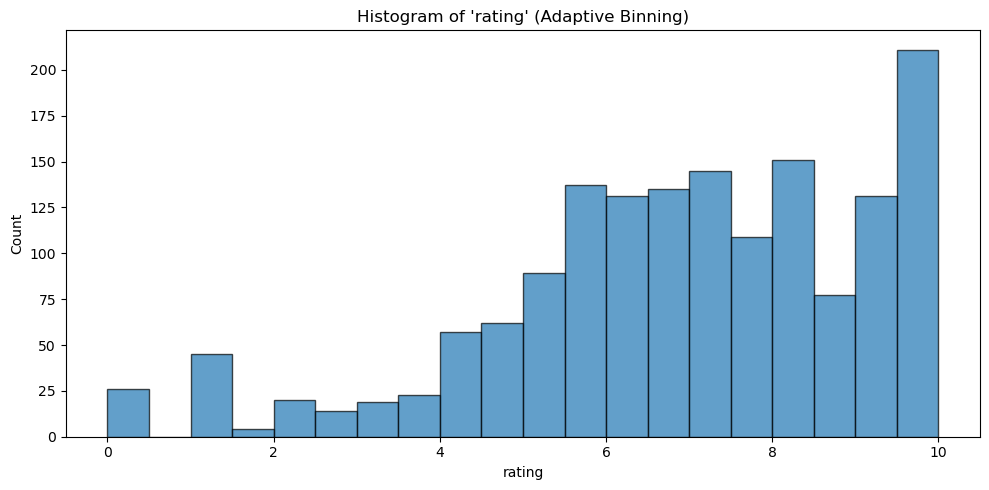

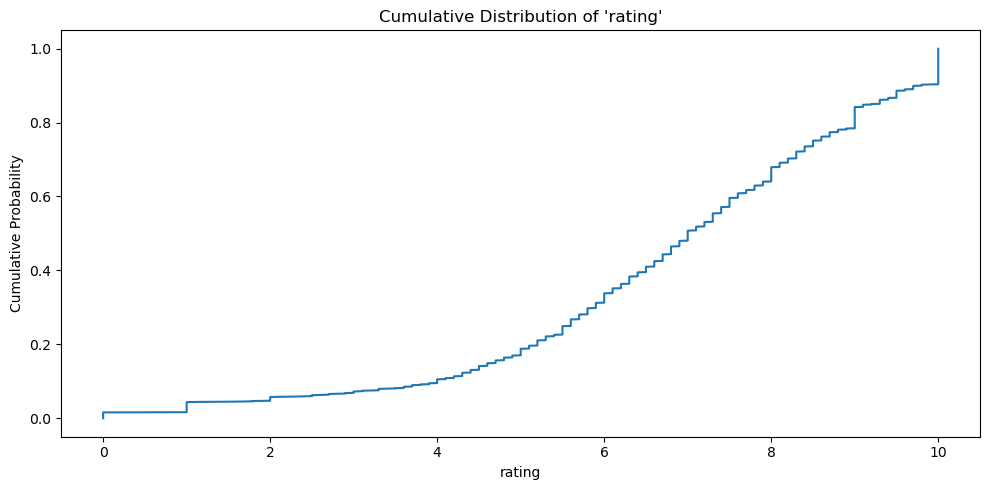

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']]

# 1️⃣ Histogram with Freedman-Diaconis rule for binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = int((target_series.max() - target_series.min()) / bin_width)
bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Cumulative Distribution Function (CDF)
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()

